In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import os

path_to_project = os.path.abspath(os.path.join(os.getcwd(), '../'))    
sys.path.insert(1, os.path.join(path_to_project))

In [2]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from src.utils import one_hot
from src.directory import data_dir, NHANES_preprocessed_filename
from src.estimators import aipw_estimator, propensity_estimator

In [3]:
NHANES_preprocessed_filepath = os.path.join(data_dir, NHANES_preprocessed_filename)
df = pd.read_csv(NHANES_preprocessed_filepath, index_col='SEQN')
df.dropna(how='any', inplace=True)

In [4]:
# features
all_cols = df.columns
z_col = 'ambient_light'
t_col = 'sleep_deprivation'
y_col = 'HTN'

# column types
categorical_cols = ['physical_activity', 'depression', 'ANTIDEPRESSANTS_ANXIOLYTICS', 'GLUCOCORTICOIDS', 'sleep_troubles',
       'sleep_deprivation', 'diabetes', 'smoker', 'race_ethnicity', 'gender', 'HTN']
numerical_cols = ['daily_sedentary', 'accelerometer', 'BMI', 'age', 'poverty_ratio', 'ambient_light']

# columns not to transform
untransformed_cols = [x for x in all_cols if x in [y_col, t_col, z_col]]

# Get histograms/descriptive stats

In [5]:
# find number of adults
n_adults = (df['age'] >= 18).sum()
print('Subjects >= 18y0:', n_adults)

Subjects >= 18y0: 4283


In [6]:
# check out range of ambient light values
df[[z_col]].describe()

,ambient_light
count,4283.000000
mean,2.586810
std,6.881204
min,0.000000
25%,0.111802
50%,0.667440
75%,2.580142
max,207.340334


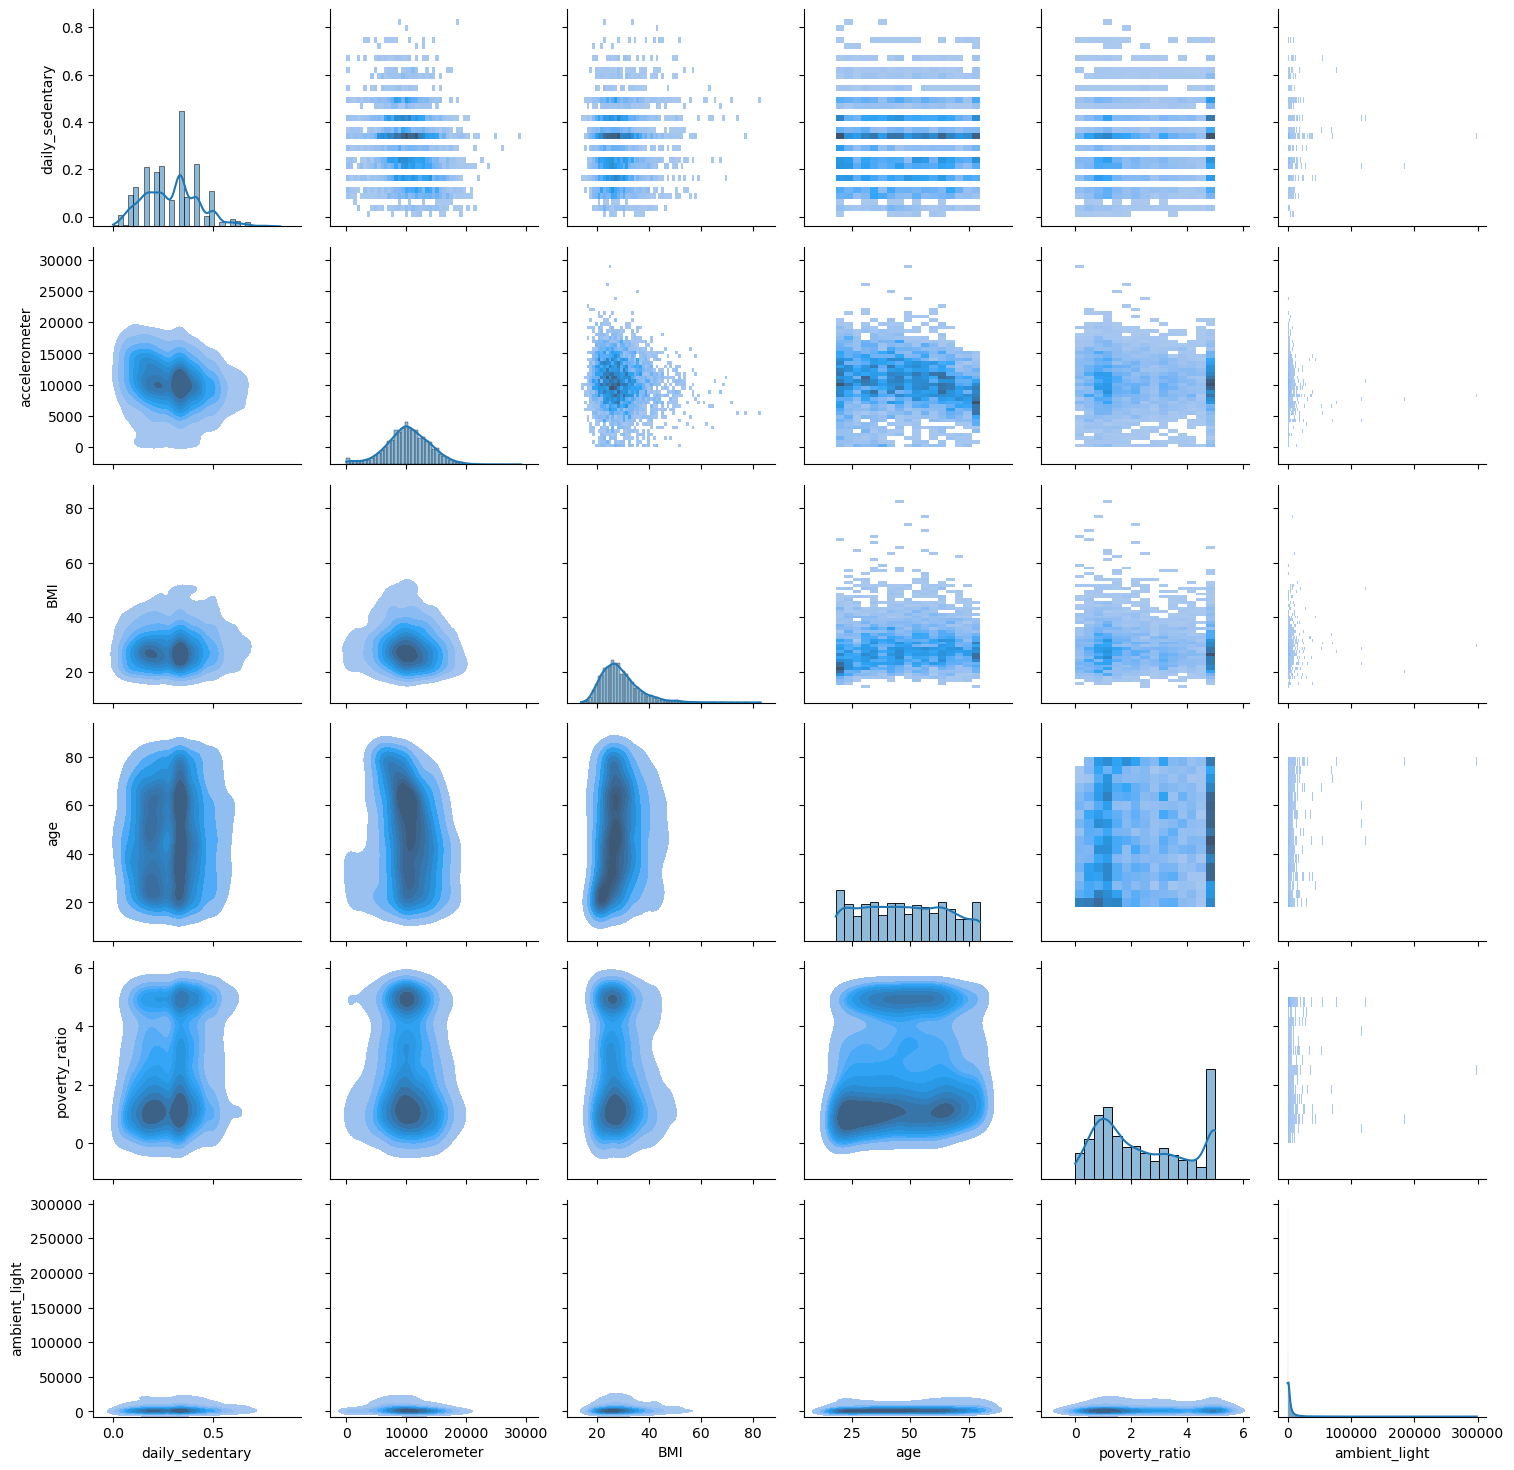

In [ ]:
g = sns.PairGrid(df[numerical_cols])
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

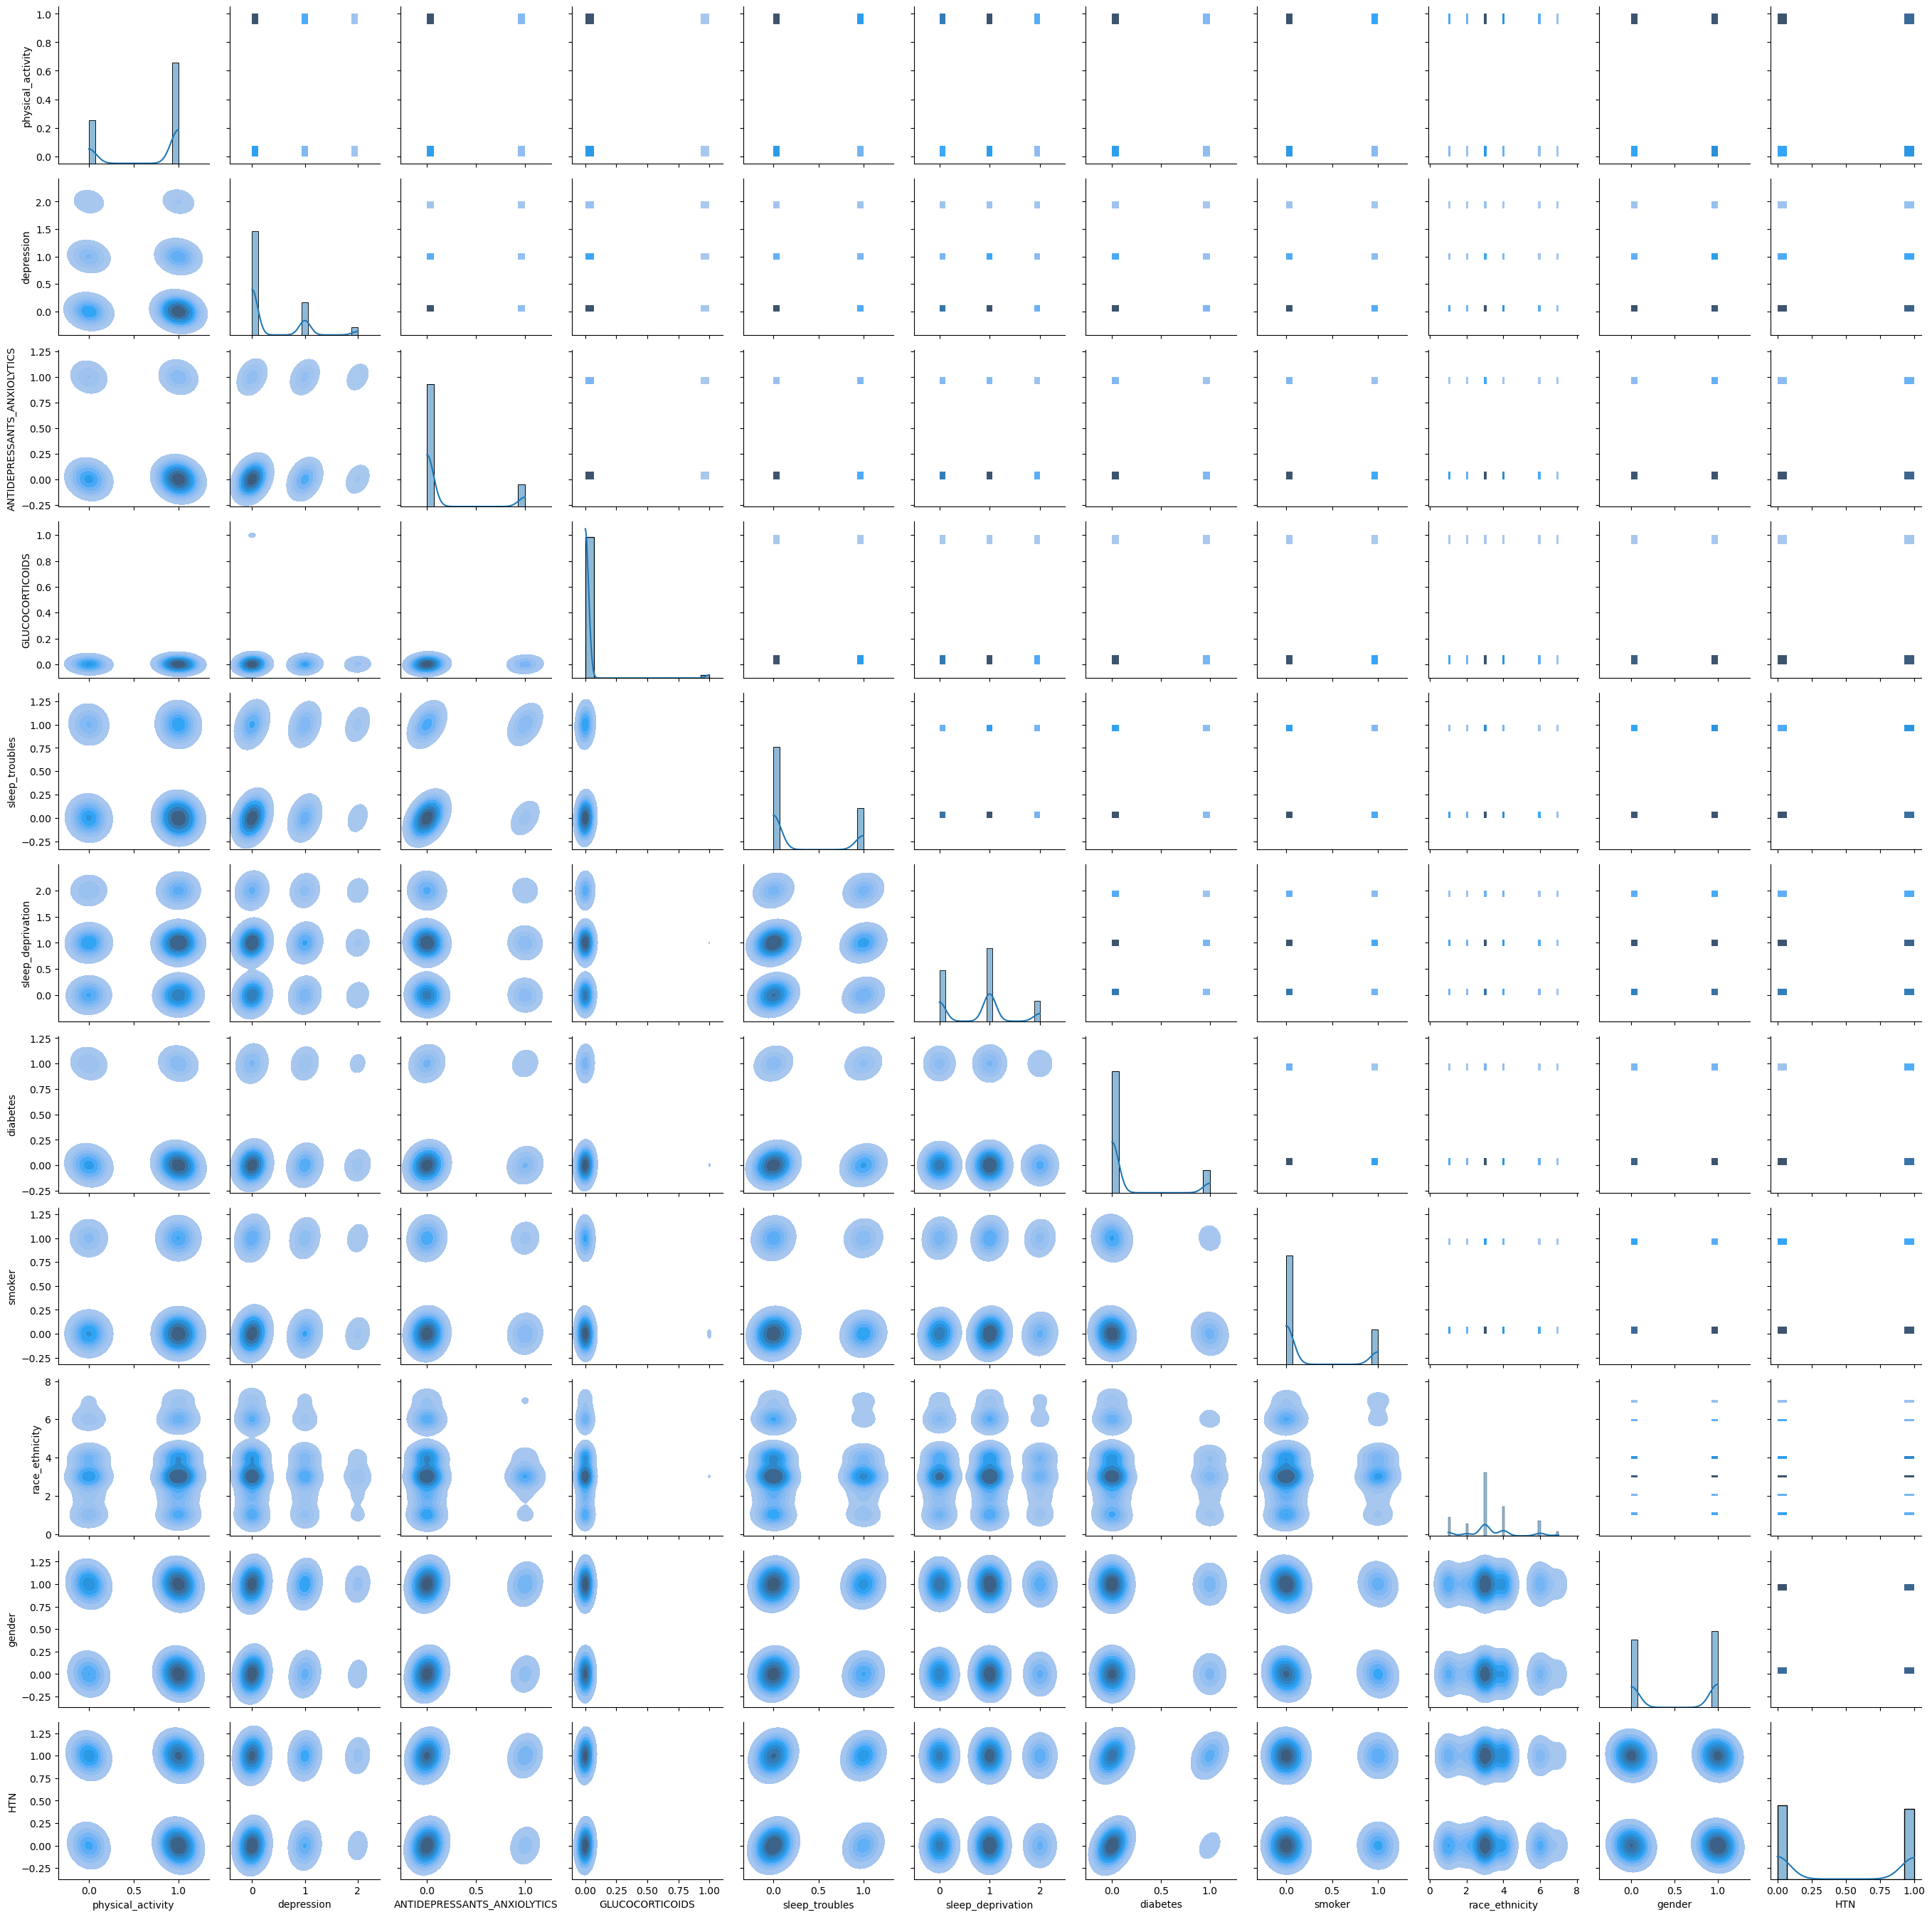

In [ ]:
g = sns.PairGrid(df[categorical_cols])
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

# Transform features for training

In [5]:
from src.data_dict import diastolic_col, systolic_col

In [6]:
# apply scalers
scaler = StandardScaler()
numerical_transformation_cols = list(set(numerical_cols) - set(untransformed_cols))
df[numerical_transformation_cols] = scaler.fit_transform(df[numerical_transformation_cols])

In [7]:
# one-hot encode categoricals
multicategory_cols = df[categorical_cols].columns[df[categorical_cols].nunique() > 2].tolist() 
multicategory_cols = list(set(multicategory_cols) - set(untransformed_cols))
df = one_hot(df, multicategory_cols)
df.columns = df.columns.str.replace('.0', '')
categorical_cols = [x for x in df.columns if any([x.startswith(y) for y in categorical_cols])]

In [8]:
# get covariates
x_cols = list(set(df.columns) - set([t_col, y_col, z_col, diastolic_col, systolic_col]))

In [9]:
# make z col binary (indicator of recommended max lux value during sleep)
light_cutoff = 1 # nightly minute-mean summed light exposure
df[z_col] = df[z_col].apply(lambda x: 1 if x <= light_cutoff else x)
df[z_col] = df[z_col].apply(lambda x: 0 if x > light_cutoff else x)

In [10]:
df = df.astype(float)

# Check assumptions

## Identification Assumptions

### Positivity

In [ ]:
X = df[[z_col, *x_cols]]
T = df[t_col]
Y = df[y_col]

propensity = propensity_estimator(X,T, multiclass=True)
propensity_cols = [f'propensity_{i}' for i in range (propensity.shape[1])]
df[propensity_cols] = propensity

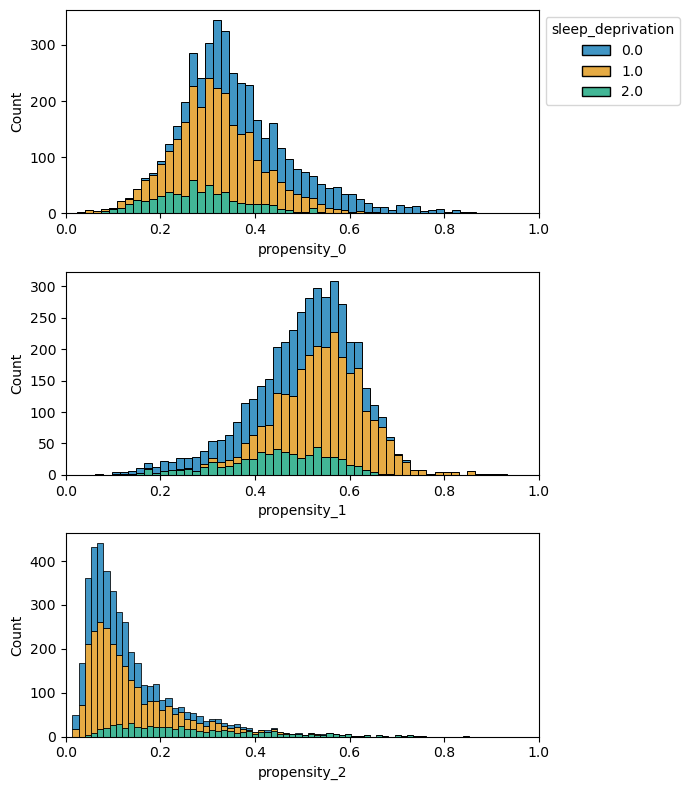

In [34]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=3, figsize=(7,8))
axs = axs.ravel()

for i, x in enumerate(propensity_cols):
    legend = True if i == 0 else False
    sns.histplot(data=df, x=x, hue="sleep_deprivation", 
                 palette='colorblind', multiple='stack', ax=axs[i],
                 legend=legend)
    if legend:
        sns.move_legend(axs[i], "upper left", bbox_to_anchor=(1, 1))
    
    axs[i].set(xlim=[0,1])
    
plt.tight_layout()

## Testing Instrumental Variable (IV) assumptions

In [11]:
import itertools
from math import ceil
import statsmodels.formula.api as smf
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [ ]:
z_cols = ['ambient_light', 'sleep_troubles'] # instrumental variable candidates

In [32]:
# 1. Relevance:
# A high F-statistic (rule of thumb: F > 10) indicates strong relevance 
for z in z_cols:
    # Check the first-stage 2SLS regression (x on z)
    first_stage = smf.ols(formula=f'{t_col} ~ {z}', data=df).fit() # {"+".join([z_col, *x_cols])}
    # print("\nFirst-stage regression:")
    # print(first_stage.summary())
    print(f"\nFirst stage F statistic, {z} : ", first_stage.fvalue)


First stage F statistic, ambient_light :  3.3312395710345784

First stage F statistic, sleep_troubles :  117.88441910239723


In [30]:
# 2. Exclusion restriction (via correlation of Z with residuals)

for z in z_cols:
    covariates = list(set(x_cols) - set(z))
    
    # Fitting the model
    linear_model = LogisticRegression()
    linear_model.fit(df[covariates], df[t_col])

    # Returning the mean accuracy for the model
    linear_acc = linear_model.score(df[covariates], df[t_col])
    print('\nMean accuracy: {0}'.format(linear_acc))

    def calculate_residuals(model, features, label):
        """
        Creates predictions on the features with the model and calculates residuals
        """
        predictions = model.predict(features)
        df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
        df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
        
        return df_results

    residuals = calculate_residuals(linear_model, df[covariates], df[t_col])
    spearman_results = spearmanr(residuals['Residuals'], df[z])
    print(f'Corr. btwn residual error and {z}: {spearman_results.statistic}, p-value={spearman_results.pvalue}')


Mean accuracy: 0.5295353724025216
Corr. btwn residual error and ambient_light: 0.015015368085211702, p-value=0.3258812562895037

Mean accuracy: 0.5295353724025216
Corr. btwn residual error and sleep_troubles: 0.07800111896893648, p-value=3.203685788640825e-07


In [ ]:
# 3. Exogeneity/Exchangeability (via regression)
# Test for correlations by regressing instruments on observed confounders
# if the coefficients of covariates are statistically significant, it indicates a correlation between the instrument and the corresponding confounder.
for z in z_cols:
    covariates = list(set(x_cols) - set(z))
    regression_z_on_covariates = smf.ols(formula=f'{z} ~ {" + ".join(covariates)}', data=df).fit()
    print(f"\nRegression of {z} on covariates:")
    print(regression_z_on_covariates.summary())


Regression of ambient_light on covariates:
                            OLS Regression Results                            
Dep. Variable:          ambient_light   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     15.15
Date:                Mon, 24 Mar 2025   Prob (F-statistic):           3.67e-48
Time:                        18:23:33   Log-Likelihood:                -2914.8
No. Observations:                4283   AIC:                             5870.
Df Residuals:                    4263   BIC:                             5997.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [ ]:
# 3. Exogeneity/Exchangeability (via correlation)
# (implies violation of exclusion restriction, exchangeability, or homogeneity assumptions)
index = pd.MultiIndex.from_product([z_cols, x_cols], names=['z', 'x'])
exogeneity_df = pd.DataFrame(columns=['r', 'pvalue'], index=index)

for z, x in itertools.product(z_cols, x_cols):
    spearman_results = spearmanr(df[z], df[x])
    exogeneity_df.loc[(z, x)] = spearman_results.statistic, spearman_results.pvalue

exogeneity_df.sort_values(by=['z', 'pvalue'], inplace=True)
print(exogeneity_df)

                                                   r    pvalue
z              x                                              
ambient_light  age                         -0.162388       0.0
               accelerometer                0.155678       0.0
               race_ethnicity_3            -0.115575       0.0
               poverty_ratio               -0.108736       0.0
               gender                       0.106578       0.0
               daily_sedentary             -0.065514  0.000018
               race_ethnicity_1             0.065106   0.00002
               diabetes                    -0.056329  0.000226
               BMI                         -0.054059  0.000401
               race_ethnicity_2             0.051526  0.000743
               ANTIDEPRESSANTS_ANXIOLYTICS -0.037872  0.013186
               smoker                       0.034301  0.024778
               race_ethnicity_6             0.027617  0.070733
               sleep_troubles              -0.027094  0

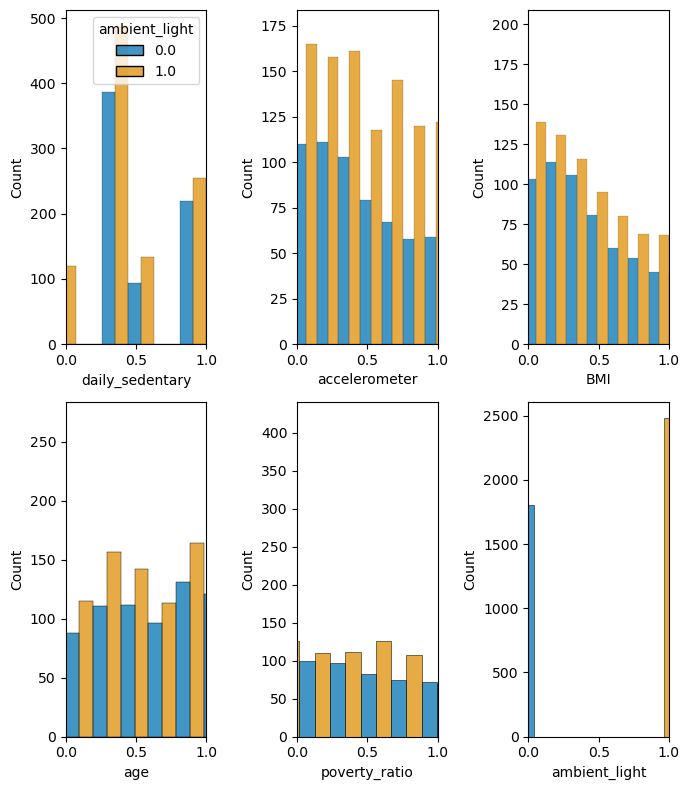

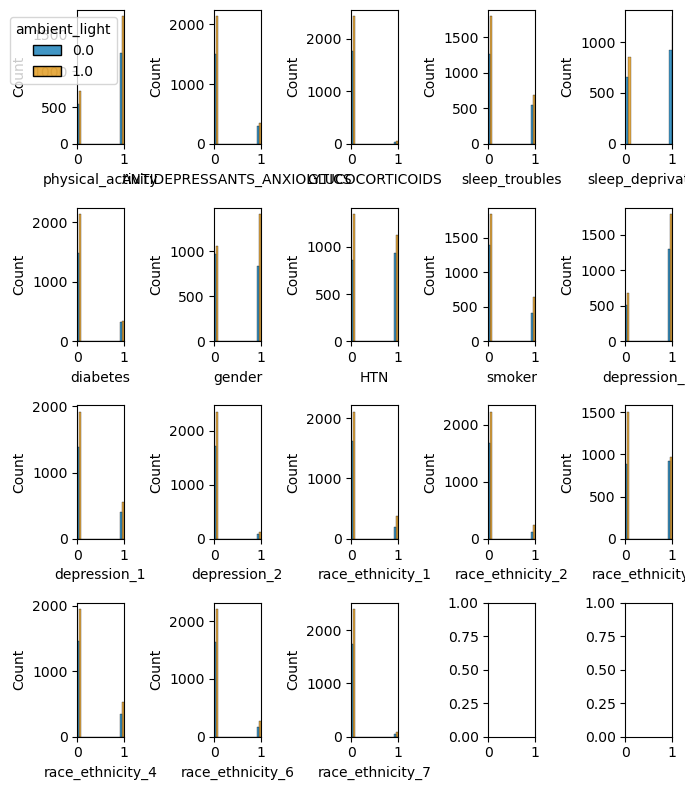

In [ ]:
# 3. Exogeneity/Exchangeability (via distribution of measured confounders across levels of the instrument to reveal potential imbalances)

for col_set in [numerical_cols, categorical_cols]:
    n_x = len(col_set)
    ncols = ceil(n_x**.5)
    fig, axs = plt.subplots(nrows=ncols-1, ncols=ncols, figsize=(7,8))
    axs = axs.ravel()
    
    for i, x_col in enumerate(col_set):
        legend = True if i == 0 else False
        sns.histplot(data=df, x=x_col, hue=z_col, 
                    palette='colorblind', multiple='dodge', ax=axs[i],
                    legend=legend)
        axs[i].set(xlim=[0,1])
        
    plt.tight_layout()